# Disaster tweet classification

## Description

The goal of this mini project is to classify tweets based on whether they are talking about real disasters as part of the Kaggle competition at https://www.kaggle.com/competitions/nlp-getting-started/overview.  

The dataset consists of 7613 tweets that have been labeled as either disaster (1) or not disaster (0) related. The test data for evaluation consists of 3263 unlabeled tweets.  

The evaluation metric for the competition is the F1 score on the test set. F1 score is the harmonic mean of Precision and Recall.

Listing the formulas for Precision, Recall and F1 score below.

Precision = TP / (TP + FP)

Recall = TP / (TP + FN)

F1 Score = 2 * (Precision * Recall) / (Precision + Recall)

where TP is the number of true positives, FP the number of false positives, and FN the number of false negatives.


## EDA


Starting by loading the training and test datasets and looking at their structure and first few rows

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras import models
from keras import layers
import tensorflow as tf

data_dir = '/workspace'


2025-06-08 10:40:02.670775: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-08 10:40:02.692968: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749379202.716751    1639 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749379202.723507    1639 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749379202.742903    1639 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
train_df = pd.read_csv(os.path.join(data_dir, 'train.csv'))
test_df = pd.read_csv(os.path.join(data_dir, 'test.csv'))

train_df.info()
test_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


The `text` column contains the tweet text and the `target` column contains the labels. I am going to ignore the other columns and just use the text for classification. 

Looking at some sample rows in the training data.

In [3]:
print(train_df[['id', 'text', 'target']].sample(5))


        id                                               text  target
367    526  One Direction Is my pick for http://t.co/y9Wvq...       0
529    767  the fall of leaves from a poplar is as fully o...       0
3970  5644  And last year it was just a lot of 'THE DRUMS ...       0
5036  7180  British bake off was great pretty hilarious mo...       0
481    691                                  anxiety attack ??       0


I am now going to plot the distribution of the labels in in the training data to see if the dataset is balanced or not.

target
0    0.57034
1    0.42966
Name: proportion, dtype: float64


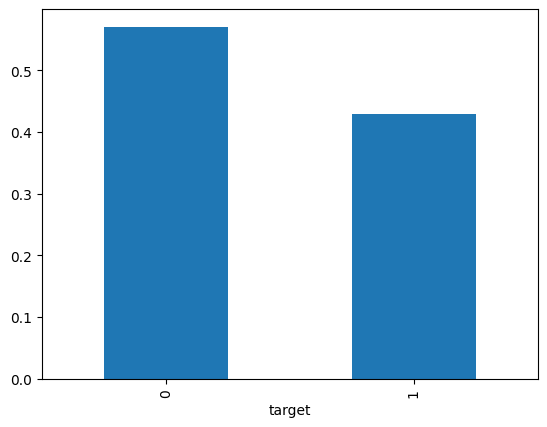

In [4]:
print(train_df['target'].value_counts(normalize=True))

train_df['target'].value_counts(normalize=True).plot(kind='bar')
plt.show()

Looks like the dataset is nearly balanced with around 57% of the tweets being non-disaster related and around 43% of the tweets being disaster related.

Now cleaning the text data by removing urls, html escape characters, punctuation, numbers and non-english characters and lower-casing the text.
I am also going to look at which words are common in each class using word clouds to see if there are any obvious patterns.

In [5]:
from sklearn.feature_extraction._stop_words import ENGLISH_STOP_WORDS
from wordcloud import WordCloud
import re


def clean_text(text):
    """
    Cleans text by removing urls, html escape characters, punctuation, numbers and non-english characters.
    Also removes stop words and lowercases the text. 
    """
    # Remove urls from text
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    # Remove html escape characters
    text = re.sub(r'&amp;', 'and', text)
    text = re.sub(r'&lt;', '<', text)
    text = re.sub(r'&gt;', '>', text)
    # Remove punctuation and numbers
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', ' ', text)
    # Remove non-english characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Lowercase the text
    text = text.lower()

    text = ' '.join([word for word in text.split() 
                     if word not in ENGLISH_STOP_WORDS 
                     if word not in ['s', 're', 'm', 've', 't']])
    return text



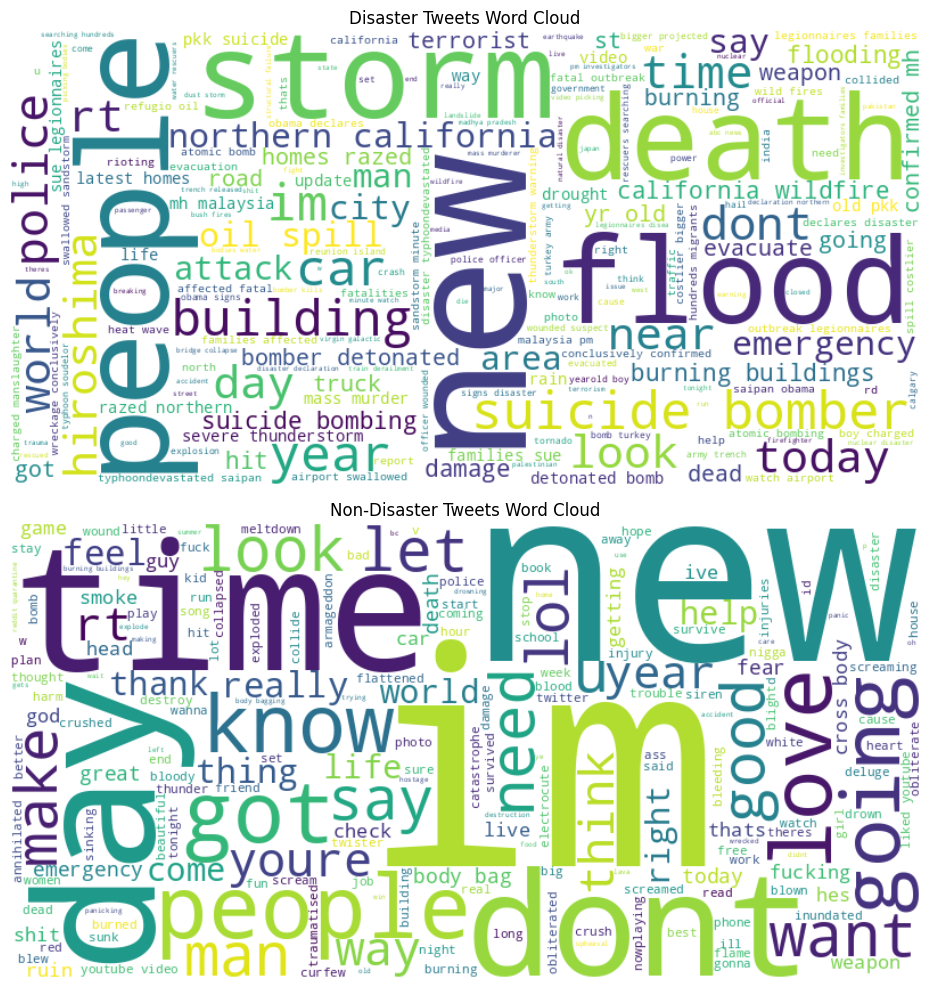

In [6]:
disaster_text = ' '.join(train_df[train_df['target'] == 1]['text'].apply(clean_text))
non_disaster_text = ' '.join(train_df[train_df['target'] == 0]['text'].apply(clean_text))

disaster_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(disaster_text)
non_disaster_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(non_disaster_text)

# Plotting wordclouds for disaster tweets and non-disaster tweets in training data
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
ax[0].imshow(disaster_wordcloud, interpolation='bilinear')
ax[0].axis('off')
ax[0].set_title('Disaster Tweets Word Cloud')
ax[1].imshow(non_disaster_wordcloud, interpolation='bilinear')
ax[1].axis('off')
ax[1].set_title('Non-Disaster Tweets Word Cloud')
plt.tight_layout()
plt.show()

Looks like disaster related words like suicide, bomber, death, news, emergency, storm, flood etc. are most common in disaster-related tweets compared to non-disaster related tweets. 

Now going to look at the vocabulary size of the training data. This will help in deciding on and tuning the word embeddings.


In [7]:
from collections import Counter

# Count the frequency of each word in the text
word_freq = Counter()
word_freq.update(disaster_text.split())
word_freq.update(non_disaster_text.split())
# Get the vocabulary size
vocab_size = len(word_freq)
print(f'Vocabulary size: {vocab_size}')

most_frequent_words = word_freq.most_common(10)
print(f'Most frequent words: {most_frequent_words}')

print(f'Maximum sequence length in training data: {train_df["text"].apply(clean_text).apply(lambda x: len(x.split())).max()}')
print(f'Maximum sequence length in test data: {test_df["text"].apply(clean_text).apply(lambda x: len(x.split())).max()}')


Vocabulary size: 16565
Most frequent words: [('like', 345), ('just', 320), ('im', 307), ('new', 226), ('dont', 208), ('news', 207), ('people', 197), ('video', 165), ('emergency', 157), ('disaster', 153)]
Maximum sequence length in training data: 21
Maximum sequence length in test data: 21


## Text Vectorization

I will use the TextVectorization layer from Keras to vectorize the text data. This layer will convert the text data into a sequence of integers, where each integer represents a word in the vocabulary. I will start with a vocabulary size of 10,000 and a maximum sequence length of 21 looking at the above analysis.

In [8]:
train_df['text'] = train_df['text'].apply(clean_text)
test_df['text'] = test_df['text'].apply(clean_text)

In [9]:

# Setting vocabulary to 15000 and max sequence length to 21
vocab_size = 15000
# Since I already cleaned the text, I will set the standardize parameter to None
text_vec_layer = layers.TextVectorization(max_tokens=vocab_size, output_sequence_length=21, standardize=None)
text_vec_layer.adapt(train_df['text'].values)

print(f'Vocabulary size: {len(text_vec_layer.get_vocabulary())}')
print(text_vec_layer.get_vocabulary()[:10])

I0000 00:00:1749379208.635649    1639 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 140828 MB memory:  -> device: 0, name: NVIDIA H200, pci bus id: 0000:ca:00.0, compute capability: 9.0


Vocabulary size: 15000
['', '[UNK]', np.str_('like'), np.str_('just'), np.str_('im'), np.str_('new'), np.str_('dont'), np.str_('news'), np.str_('people'), np.str_('video')]


In [10]:
print(train_df['text'].values[:3])
text_vec_layer(train_df['text'].values[:3])

['deeds reason earthquake allah forgive'
 'forest near la ronge sask canada'
 'residents asked shelter place notified officers evacuation shelter place orders expected']


E0000 00:00:1749379212.735980    2191 ptx_compiler_helpers.cc:88] *** WARNING *** Invoking ptxas with version 12.1.105, which corresponds to a CUDA version <=12.6.2. CUDA versions 12.x.y up to and including 12.6.2 miscompile certain edge cases around clamping.
Please upgrade to CUDA 12.6.3 or newer.


<tf.Tensor: shape=(3, 21), dtype=int64, numpy=
array([[ 5742,   656,   125,  1460,  5491,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0],
       [   76,   106,   497,  8807,  8615,  1214,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0],
       [ 1510,  1455,  1901,   508, 10187,  1531,   124,  1901,   508,
         1171,   910,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0]])>

Looking at the output of text vectorization layer, we can an see that the text data has been converted into a sequence of integers.  

Now the integers assigned to the words are arbitrary and this is not a good representation of the text data. We need to convert these integers into a meaningful representation. This can be done using an embedding layer. With word embeddings, we can convert the integers into a dense vector representation of the words. Similar words will have similar vector representations.

I will create an embedding layer and see how it works.

In [11]:
embedding_layer = layers.Embedding(input_dim=vocab_size, output_dim=64)
embedding_layer(text_vec_layer(train_df['text'].values[:3]))

<tf.Tensor: shape=(3, 21, 64), dtype=float32, numpy=
array([[[-4.9118686e-02,  3.8777258e-02, -4.0607441e-02, ...,
         -4.4452440e-02, -6.3841566e-03,  2.9692922e-02],
        [-4.7977518e-02, -1.0148238e-02,  1.4955290e-03, ...,
         -3.0561388e-02,  4.9459781e-02, -4.3639161e-02],
        [ 2.7229596e-02, -4.3919660e-02, -1.1889540e-02, ...,
          1.1961270e-02, -2.6365161e-02,  3.3718515e-02],
        ...,
        [ 3.9033558e-02, -1.4775179e-02, -3.0958056e-03, ...,
          4.1252110e-02, -4.4580318e-02,  4.3116841e-02],
        [ 3.9033558e-02, -1.4775179e-02, -3.0958056e-03, ...,
          4.1252110e-02, -4.4580318e-02,  4.3116841e-02],
        [ 3.9033558e-02, -1.4775179e-02, -3.0958056e-03, ...,
          4.1252110e-02, -4.4580318e-02,  4.3116841e-02]],

       [[ 3.2541975e-03, -3.8596354e-02, -3.9894521e-02, ...,
         -2.9436834e-03, -7.5048693e-03,  3.2725301e-02],
        [-4.4132840e-02,  2.5494110e-02,  9.2635304e-04, ...,
         -7.5670704e-03, -4.84

As we can see, the integers are converted into 64 dimensional vectors. 

## Model Building and Analysis

Now I will use these vector embeddings to train a model and see how it performs. I will start with a simple LSTM model and see if adding more layers or using bidirectional LSTM improves the performance. I will also try to see how a GRU model performs compared to LSTM. 

First defining a few functions to help train models and plot training histories.

In [12]:
def plot_training_history(history):
    """
    Plot the training and validation loss and accuracy against the number of epochs.
    Parameters:
    - history: History object returned by the fit method of a Keras model
    """
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()
    

def train_model(model, model_name, X, y, epochs=100, batch_size=32, validation_split=0.2,
                optimizer='Adam', loss='binary_crossentropy',
                plot_history=True):
    """
    Trains a Keras model with the given data and saves the best weights based on validation AUC.
    Stops early if there is no improvement in validation AUC for 10 epochs.
    Using validation AUC for calculating best weights as this is the scoring critieria
    for the kaggle competition.
    Parameters:
    - model: Keras model to train.
    - model_name: String, name of the model used for naming the weights file.
    - X: Training data.
    - y: Training labels.
    - epochs: Integer, number of epochs to train.
    - batch_size: Integer, batch size for training.
    - validation_split: Float, fraction of data to use for validation.
    - optimizer: Keras optimizer.
    - loss: Keras loss function.
    - plot_history: Boolean, whether to plot the training history.
    Returns:
    - Trained Keras model with the best weights loaded.
    """

    # Figure out how to integrate F1Score into the metrics
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy', keras.metrics.F1Score(threshold=0.5)])
    checkpointer = keras.callbacks.ModelCheckpoint(
        f'{model_name}.best_weights.keras', 
        save_best_only=True,
        verbose=1,
        monitor='val_f1_score',
        mode='max')
    early_stopping = keras.callbacks.EarlyStopping(
        patience=5,
        verbose=1) 

    history = model.fit(X, y, epochs=epochs, batch_size=batch_size, validation_split=validation_split, 
                        callbacks=[checkpointer, early_stopping])
    
    if plot_history:
        plot_training_history(history)

    model.load_weights(f'{model_name}.best_weights.keras')
    return model # , history

 
def evaluate_model_and_print_results(model, X_test, y_test):
    """
    Evaluates the model on the test data and prints the results.
    Parameters:
    - model: Keras model to evaluate.
    - X_test: Test data.
    - y_test: Test labels.
    """
    test_loss, test_accuracy, test_f1score = model.evaluate(X_test, y_test)
    print(f'Test Loss: {test_loss}')
    print(f'Test Accuracy: {test_accuracy}')
    print(f'Test F1 Score: {test_f1score}')

### Simple LSTM model with dropout



In [13]:
# LSTM model
model = models.Sequential([
    layers.InputLayer(shape=train_df['text'].values.shape[1:], dtype=tf.string),
    text_vec_layer,
    embedding_layer,
    layers.LSTM(50),
    layers.Dropout(0.2),
    layers.Dense(50, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid'),
]) 

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 21)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 21, 64)         │       960,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 50)             │        23,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 985,601 (3.76 MB)

 Trainable params: 985,601 (3.76 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


I0000 00:00:1749379218.230782    2182 cuda_dnn.cc:529] Loaded cuDNN version 90300


191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6048 - f1_score: 0.2561 - loss: 0.6523
Epoch 1: val_f1_score improved from -inf to 0.69459, saving model to lstm_model.best_weights.keras
191/191 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - accuracy: 0.6053 - f1_score: 0.2573 - loss: 0.6519 - val_accuracy: 0.7702 - val_f1_score: 0.6946 - val_loss: 0.4897
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8734 - f1_score: 0.8373 - loss: 0.3451
Epoch 2: val_f1_score improved from 0.69459 to 0.74834, saving model to lstm_model.best_weights.keras
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.8733 - f1_score: 0.8373 - loss: 0.3451 - val_accuracy: 0.7505 - val_f1_score: 0.7483 - val_loss: 0.5129
Epoch 3/20
190/191 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9360 - f1_score: 0.9239 - loss: 0.1948
Epoch 3: val_f1_score did not improve from 0.74834
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.9360 - f1_score: 0.9238 - loss: 0.1949 - val_accuracy: 0.7157 - 

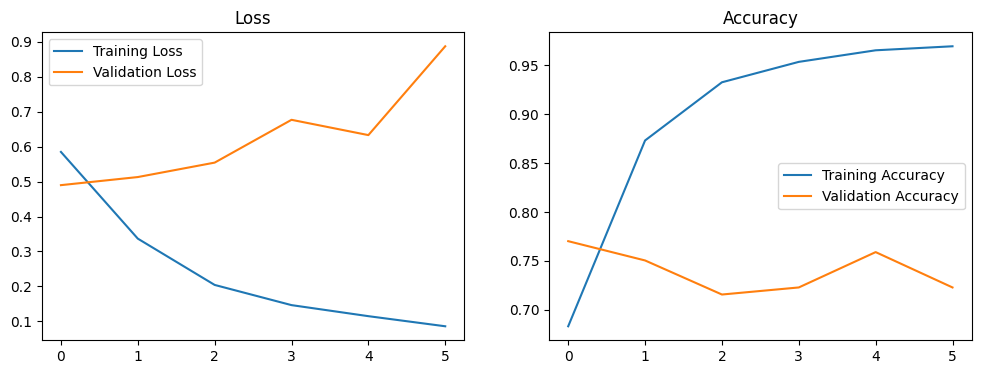

In [14]:
model = train_model(model, 'lstm_model', train_df['text'].values, train_df['target'],
                    epochs=20, batch_size=32) 

In [15]:
Ypred = model.predict(test_df['text'].values)
Ypred = np.round(Ypred).astype(int)
test_df['target'] = Ypred
test_df.to_csv('nlp_disaster_tweets_submission_lstm_simple.csv', columns=['id', 'target'], index=False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step  


Seems like even this simple model is overfitting a bit. My score on the kaggle leaderboard is 0.76524 for this model on the test data.  
I will see if I can improve this with a bidirectional LSTM model.

### Bidirectional LSTM model



In [16]:
# Bidirectional LSTM model
model2 = models.Sequential([
    layers.InputLayer(shape=train_df['text'].values.shape[1:], dtype=tf.string),
    text_vec_layer,
    layers.Embedding(input_dim=vocab_size, output_dim=64),
    layers.Bidirectional(layers.LSTM(50)),
    layers.Dropout(0.2),
    layers.Dense(50, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid'),
]) 

model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 21)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 21, 64)         │       960,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 100)            │        46,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,011,101 (3.86 MB)

 Trainable params: 1,011,101 (3.86 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
190/191 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5492 - f1_score: 0.1575 - loss: 0.6885
Epoch 1: val_f1_score improved from -inf to 0.00000, saving model to lstm_model_bidirectional.best_weights.keras
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - accuracy: 0.5494 - f1_score: 0.1566 - loss: 0.6885 - val_accuracy: 0.5345 - val_f1_score: 0.0000e+00 - val_loss: 0.6868
Epoch 2/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5877 - f1_score: 9.7977e-04 - loss: 0.6714
Epoch 2: val_f1_score improved from 0.00000 to 0.00843, saving model to lstm_model_bidirectional.best_weights.keras
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.5877 - f1_score: 0.0010 - loss: 0.6714 - val_accuracy: 0.5364 - val_f1_score: 0.0084 - val_loss: 0.6689
Epoch 3/100
190/191 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6356 - f1_score: 0.2718 - loss: 0.6323
Epoch 3: val_f1_score improved from 0.00843 to 0.67133, saving model to lstm_model_bidirectional.best_weights.keras
191/19

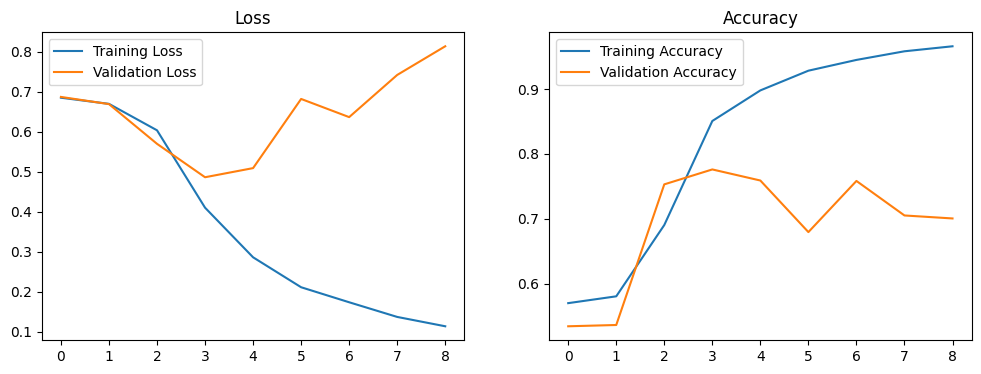

In [17]:
model2 = train_model(model2, 'lstm_model_bidirectional', train_df['text'].values, train_df['target'],
                    epochs=100, batch_size=32, optimizer=keras.optimizers.Adam(learning_rate=0.0001)) 

In [18]:
Ypred = model2.predict(test_df['text'].values)
Ypred = np.round(Ypred).astype(int)
test_df['target'] = Ypred
test_df.to_csv('nlp_disaster_tweets_submission_lstm_bidirectional.csv', columns=['id', 'target'], index=False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step  


This model scored 0.78057 on kaggle. The score improved a bit on the previous model. 

### GRU Model

In [19]:
# GRU model
model3 = models.Sequential([
    layers.InputLayer(shape=train_df['text'].values.shape[1:], dtype=tf.string),
    text_vec_layer,
    layers.Embedding(input_dim=vocab_size, output_dim=64),
    layers.GRU(50),
    layers.Dropout(0.2),
    layers.Dense(50, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid'),
]) 

model3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 21)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ (None, 21, 64)         │       960,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 50)             │        17,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 980,001 (3.74 MB)

 Trainable params: 980,001 (3.74 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
190/191 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5399 - f1_score: 0.3382 - loss: 0.6903
Epoch 1: val_f1_score improved from -inf to 0.00000, saving model to gru_model.best_weights.keras
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.5402 - f1_score: 0.3368 - loss: 0.6902 - val_accuracy: 0.5345 - val_f1_score: 0.0000e+00 - val_loss: 0.6920
Epoch 2/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5863 - f1_score: 0.0028 - loss: 0.6812    
Epoch 2: val_f1_score did not improve from 0.00000
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.5863 - f1_score: 0.0028 - loss: 0.6812 - val_accuracy: 0.5345 - val_f1_score: 0.0000e+00 - val_loss: 0.6922
Epoch 3/100
189/191 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5808 - f1_score: 0.0000e+00 - loss: 0.6820
Epoch 3: val_f1_score did not improve from 0.00000
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.5807 - f1_score: 0.0000e+00 - loss: 0.6820 - val_accuracy: 0.5345 - val_f1_score: 0.000

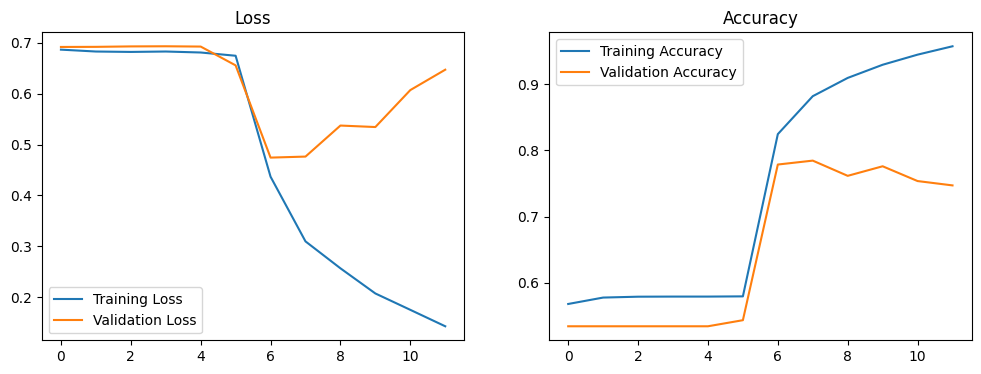

In [20]:
model3 = train_model(model3, 'gru_model', train_df['text'].values, train_df['target'],
                    epochs=100, batch_size=32, optimizer=keras.optimizers.Adam(learning_rate=0.0001)) 

In [21]:
Ypred = model3.predict(test_df['text'].values)
Ypred = np.round(Ypred).astype(int)
test_df['target'] = Ypred
test_df.to_csv('nlp_disaster_tweets_submission_gru.csv', columns=['id', 'target'], index=False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step   


This scored 0.78639 on kaggle test data. Scored the same as bidirectional LSTM. 

### Bidirectional GRU model


In [22]:
# Bidirectional GRU model
model4 = models.Sequential([
    layers.InputLayer(shape=train_df['text'].values.shape[1:], dtype=tf.string),
    text_vec_layer,
    layers.Embedding(input_dim=vocab_size, output_dim=64),
    layers.Bidirectional(layers.GRU(50)),
    layers.Dropout(0.2),
    layers.Dense(50, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid'),
]) 

model4.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 21)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_3 (Embedding)         │ (None, 21, 64)         │       960,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 100)            │        34,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 999,901 (3.81 MB)

 Trainable params: 999,901 (3.81 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
190/191 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5289 - f1_score: 0.2655 - loss: 0.6898
Epoch 1: val_f1_score improved from -inf to 0.00000, saving model to bidirectional_gru_model.best_weights.keras
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - accuracy: 0.5292 - f1_score: 0.2643 - loss: 0.6897 - val_accuracy: 0.5345 - val_f1_score: 0.0000e+00 - val_loss: 0.6886
Epoch 2/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5753 - f1_score: 0.0106 - loss: 0.6773
Epoch 2: val_f1_score improved from 0.00000 to 0.04952, saving model to bidirectional_gru_model.best_weights.keras
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.5754 - f1_score: 0.0107 - loss: 0.6772 - val_accuracy: 0.5463 - val_f1_score: 0.0495 - val_loss: 0.6683
Epoch 3/100
190/191 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6858 - f1_score: 0.4063 - loss: 0.6030
Epoch 3: val_f1_score improved from 0.04952 to 0.76286, saving model to bidirectional_gru_model.best_weights.keras
191/191 ━━━━━

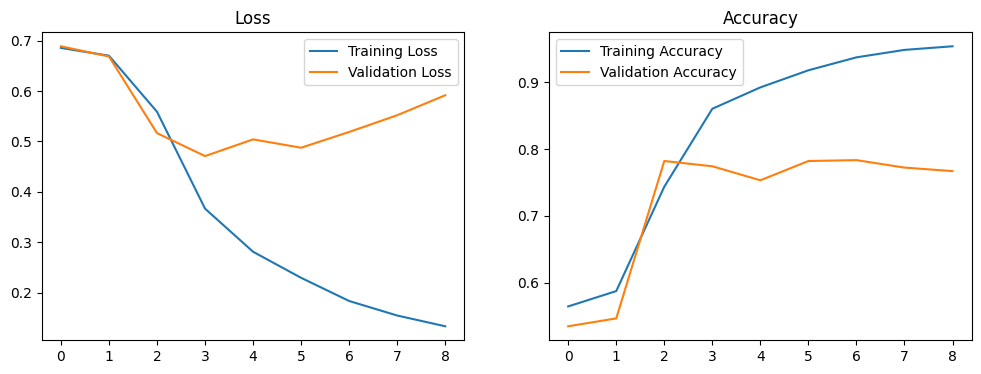

In [23]:
model4 = train_model(model4, 'bidirectional_gru_model', train_df['text'].values, train_df['target'],
                     epochs=100, batch_size=32, optimizer=keras.optimizers.Adam(learning_rate=0.0001)) 

In [24]:
Ypred = model4.predict(test_df['text'].values)
Ypred = np.round(Ypred).astype(int)
test_df['target'] = Ypred
test_df.to_csv('nlp_disaster_tweets_submission_bidirectional_gru.csv', columns=['id', 'target'], index=False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step  


This scored 0.78761 on Kaggle test data which is similar to previous 2 models. I will now try to increase the embedding dimensions and also use more units to see if a more complex model improves the performance.

### Bigger model


In [25]:
# Big bidirectional LSTM model
model5 = models.Sequential([
    layers.InputLayer(shape=train_df['text'].values.shape[1:], dtype=tf.string),
    text_vec_layer,
    layers.Embedding(input_dim=vocab_size, output_dim=128),
    layers.Bidirectional(layers.LSTM(128, return_sequences=True)),
    layers.Dropout(0.2),
    layers.Bidirectional(layers.LSTM(64)),
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid'),
]) 

model5.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 21)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_4 (Embedding)         │ (None, 21, 128)        │     1,920,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 21, 256)        │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 21, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,364,161 (9.02 MB)

 Trainable params: 2,364,161 (9.02 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5845 - f1_score: 0.0904 - loss: 0.6843
Epoch 1: val_f1_score improved from -inf to 0.00000, saving model to big_lstm_model.best_weights.keras
191/191 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.5845 - f1_score: 0.0901 - loss: 0.6843 - val_accuracy: 0.5338 - val_f1_score: 0.0000e+00 - val_loss: 0.6747
Epoch 2/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6563 - f1_score: 0.3078 - loss: 0.6112
Epoch 2: val_f1_score improved from 0.00000 to 0.74382, saving model to big_lstm_model.best_weights.keras
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.6567 - f1_score: 0.3093 - loss: 0.6108 - val_accuracy: 0.7617 - val_f1_score: 0.7438 - val_loss: 0.4885
Epoch 3/100
190/191 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8749 - f1_score: 0.8476 - loss: 0.3217
Epoch 3: val_f1_score improved from 0.74382 to 0.74606, saving model to big_lstm_model.best_weights.keras
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/st

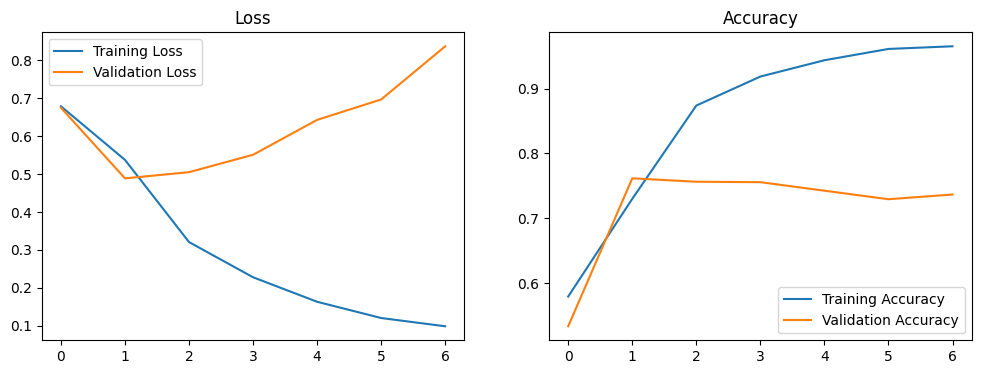

In [26]:
model5 = train_model(model5, 'big_lstm_model', train_df['text'].values, train_df['target'],
                     epochs=100, batch_size=32, optimizer=keras.optimizers.Adam(learning_rate=0.0001)) 

In [27]:
Ypred = model5.predict(test_df['text'].values)
Ypred = np.round(Ypred).astype(int)
test_df['target'] = Ypred
test_df.to_csv('nlp_disaster_tweets_submission_big_lstm.csv', columns=['id', 'target'], index=False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


This scored 0.77076 on kaggle which is a bit less than before. It's probably overfitting a bit.

## Results and conclusion

Summarizing the results from different models below

| Model | Kaggle Score |
| ----- | --- |
| LSTM  | 0.76524 |
| Bidirectional LSTM | 0.78057 |
| GRU | 0.78639 |
| Bidirectional GRU | 0.78761 |
| Multilayer LSTM | 0.77076 |


Looking at the results, seems like there isn't much improvement from even simpler LSTM/GRU models to more complex ones and the training history shows overfitting even with very few epochs. Considering the training data is very small (Only 7613 tweets), there's probably won't be much improvement from larger RNN models.  

I think possible ways in which to improve the performance of this task is to try out other machine learning models that perform better on smaller text data or even try out other ways to clean up or process the text to extract the features better. 

## References


1. https://keras.io/api/layers/preprocessing_layers/text/text_vectorization/
2. https://keras.io/2/api/layers/core_layers/embedding/
3. https://www.tensorflow.org/text/guide/word_embeddings